In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad
mpl.rcParams['font.family'] = 'serif'

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import numpy as np
import math,random
from math import exp, sqrt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, action_dim),
            nn.Tanh()
        )
        # critic
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        # variance
        self.action_var = torch.full((action_dim,), action_std * action_std).to(device)

    def forward(self):
        raise NotImplementedError

    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)

        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)

        return action.detach()

    def evaluate(self, state, action):
        action_mean = self.actor(state)

        action_var = self.action_var.expand_as(action_mean)
        # torch.diag_embed(input, offset=0, dim1=-2, dim2=-1) → Tensor
        # Creates a tensor whose diagonals of certain 2D planes (specified by dim1 and dim2) are filled by input
        cov_mat = torch.diag_embed(action_var).to(device)
        # generate multivariate normal
        dist = MultivariateNormal(action_mean, cov_mat)
        # use the random one to approximate the gaussian to choose action
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)

        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs), 1).to(device).detach()
		# use the samples several times to increase the using rate
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

In [3]:
# CRR American Option
def CRR_american_option_value(S0, K, T, r, sigma, otype, M=4):
    # generate binomial tree
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount per interval
    inf = math.exp(r * dt)  # discount per interval

    # calculate u, d, p
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # initialized the matrix
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # calculate the stock price change at each node
    mus = u ** (mu - md)
    mds = d ** md
    
    # get the stock price at each node
    S = S0 * mus * mds 
        
    # calculate the expected stock price at each node
    mes = S0 * inf ** mu

    # get the option value at leaf nodde
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        # calculate the payoff for earlier exercise at each node
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        # calculate the payoff for earlier exercise at each node
        oreturn = K - mes

    # get the option value by comparing the payoff for exercise and continue
    for z in range(0, M):  # backwards iteration
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        # update the option value
        # choose the max value between the payoff for exercise and continue
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V[0, 0]

In [4]:
############## Hyperparameters ##############
render = False
solved_reward = 300  # stop training if avg_reward > solved_reward
log_interval = 20  # print avg reward in the interval
max_episodes = 1000  # max training episodes
max_timesteps = 1500  # max timesteps in one episode

update_timestep = 4000  # update policy every n timesteps
action_std = 0.5  # constant std for action distribution (Multivariate Normal)
K_epochs = 80  # update policy for K epochs
eps_clip = 0.2  # clip parameter for PPO
gamma = 0.99  # discount factor

lr = 0.0003  # parameters for Adam optimizer
betas = (0.9, 0.999)

#############################################

# creating environment
state_dim = 1
action_dim = 3

memory = Memory()
ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
#print(lr, betas)

# logging variables
running_reward = 0
avg_length = 0
time_step = 0

mmin=2
mmax=200
step_size=1

# input parameters
S0 = 100.0  # index level
K = 100.0  # option strike
T = 10.0  # maturity date
r = 0.05  # risk-less short rate
sigma = 0.2  # volatility

avg_reward=np.array([])

# training loop
for i_episode in range(1, max_episodes + 1):
    buyvalue=0
    done=False
    for it in range(mmin, mmax, step_size):
        CRR_values = CRR_american_option_value(S0, K, T, r, sigma, 'put', it)
        time_step += 1
        # Running policy_old:
        action = ppo.select_action(CRR_values, memory)
        #print(action)
        CRR_values_new = CRR_american_option_value(S0, K, T, r, sigma, 'put', it+step_size)
        if np.argmax(action)==0:
            reward=0
        elif np.argmax(action)==1:
            buyvalue=CRR_values
            reward=0
        elif np.argmax(action)==2:
            if buyvalue>0:
                reward=CRR_values_new-buyvalue
            else:
                reward=0
            buyvalue=0
        
        running_reward += reward
        #print("A-R:",np.argmax(action),reward)
        #state, reward, done, _ = env.step(action)

        if it ==mmax-1:
            done=True
        # Saving reward and is_terminals:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        running_reward += reward
        if done:
            break

    # logging
    if i_episode % log_interval == 0:
        running_reward = running_reward / log_interval
        avg_reward=np.append(avg_reward,running_reward)
        print('Episode {} \t Avg reward: {}'.format(i_episode, running_reward))
        running_reward = 0

Episode 20 	 Avg reward: 0.8547773403773039
Episode 40 	 Avg reward: 0.5816864826138767
Episode 60 	 Avg reward: 1.2989761736941936
Episode 80 	 Avg reward: 1.4069170327669198
Episode 100 	 Avg reward: 2.108046776673345
Episode 120 	 Avg reward: 2.160722658613433
Episode 140 	 Avg reward: 1.7215971015436409
Episode 160 	 Avg reward: 2.35011611231736
Episode 180 	 Avg reward: 3.316272151764218
Episode 200 	 Avg reward: 2.1396149856052977
Episode 220 	 Avg reward: 2.558556717942294
Episode 240 	 Avg reward: 2.0190800968250726
Episode 260 	 Avg reward: 3.1813467509707296
Episode 280 	 Avg reward: 3.451521997061465
Episode 300 	 Avg reward: 3.4456329614375276
Episode 320 	 Avg reward: 3.91043807691437
Episode 340 	 Avg reward: 3.2825579107001546
Episode 360 	 Avg reward: 3.432097299267606
Episode 380 	 Avg reward: 2.6959842548617905
Episode 400 	 Avg reward: 3.1865443392535306
Episode 420 	 Avg reward: 3.1838615327982978
Episode 440 	 Avg reward: 3.9422807031672633
Episode 460 	 Avg reward

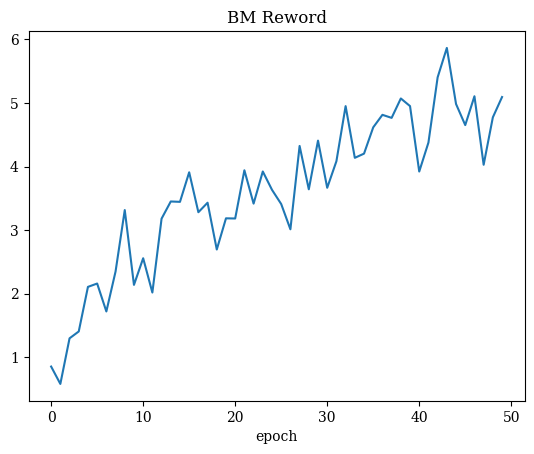

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(avg_reward)
plt.title("BM Reword")
plt.xlabel("epoch")
plt.show()

In [6]:
#布朗运动美式期权
def gbm(S, v, r, T):
    return S * exp((r - 0.5 * v**2) * T + v * sqrt(T) * random.gauss(0,1.0))

In [7]:
############## Hyperparameters ##############
render = False
solved_reward = 300  # stop training if avg_reward > solved_reward
log_interval = 20  # print avg reward in the interval
max_episodes = 1000  # max training episodes
max_timesteps = 1500  # max timesteps in one episode

update_timestep = 4000  # update policy every n timesteps
action_std = 0.5  # constant std for action distribution (Multivariate Normal)
K_epochs = 80  # update policy for K epochs
eps_clip = 0.2  # clip parameter for PPO
gamma = 0.99  # discount factor

lr = 0.0003  # parameters for Adam optimizer
betas = (0.9, 0.999)

#############################################

# creating environment
state_dim = 1
action_dim = 3

memory = Memory()
ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
#print(lr, betas)

# logging variables
running_reward = 0
avg_length = 0
time_step = 0

mmin=2
mmax=200
step_size=1

# input paramaters
S = 40.0 # asset price
v = 0.2 # vol of 20%
r = 0.01 # rate of 1%
maturity = 0.5
K = 40.0 # ATM strike
simulations = 200

avg_reward=np.array([])
# training loop
for i_episode in range(1, max_episodes + 1):
    buyvalue=0
    done=False
    for it in range(mmin, mmax, step_size):
        CRR_values = gbm(S, v, r, maturity)
        time_step += 1
        # Running policy_old:
        action = ppo.select_action(np.array([CRR_values]), memory)
        #print(action)
        CRR_values_new = gbm(S, v, r, maturity)
        if np.argmax(action)==0:
            reward=0
        elif np.argmax(action)==1:
            buyvalue=CRR_values
            reward=0
        elif np.argmax(action)==2:
            if buyvalue>0:
                reward=CRR_values_new-buyvalue
            else:
                reward=0
            buyvalue=0
        
        running_reward += reward
        #print("A-R:",np.argmax(action),reward)
        #state, reward, done, _ = env.step(action)

        if it ==mmax-1:
            done=True
        # Saving reward and is_terminals:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        running_reward += reward
        if done:
            break

    # logging
    if i_episode % log_interval == 0:
        running_reward = running_reward / log_interval
        avg_reward=np.append(avg_reward,running_reward)
        print('Episode {} \t Avg reward: {}'.format(i_episode, running_reward))
        running_reward = 0

Episode 20 	 Avg reward: -0.012159164921894571
Episode 40 	 Avg reward: 2.753720723552207
Episode 60 	 Avg reward: -21.744224449401504
Episode 80 	 Avg reward: 46.58903736894786
Episode 100 	 Avg reward: 25.01204051288309
Episode 120 	 Avg reward: 75.02987232278542
Episode 140 	 Avg reward: 82.08493038322813
Episode 160 	 Avg reward: 100.49504406606957
Episode 180 	 Avg reward: 133.31867450067892
Episode 200 	 Avg reward: 143.11014336266453
Episode 220 	 Avg reward: 174.0984893616976
Episode 240 	 Avg reward: 121.80678709060366
Episode 260 	 Avg reward: 173.6423888244792
Episode 280 	 Avg reward: 146.3100069380037
Episode 300 	 Avg reward: 224.51112116695975
Episode 320 	 Avg reward: 220.06435972839228
Episode 340 	 Avg reward: 259.88784599460666
Episode 360 	 Avg reward: 278.9847848903264
Episode 380 	 Avg reward: 294.0487463925866
Episode 400 	 Avg reward: 305.9967039267138
Episode 420 	 Avg reward: 299.74957288250636
Episode 440 	 Avg reward: 305.38344126963204
Episode 460 	 Avg rew

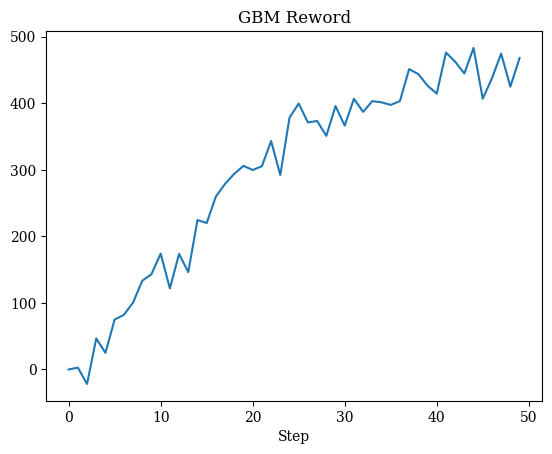

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(avg_reward)
plt.title("GBM Reword")
plt.xlabel("Step")
plt.show()